In [1]:
import os
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import random

## Image Loading

In [2]:
def load_images_from_folder(root_dir, image_size=(244, 244)):
    image_data = []
    labels = []
    class_names = sorted(os.listdir(root_dir))
    class_to_idx = {class_name: idx for idx, class_name in enumerate(class_names)}

    for class_name in class_names:
        class_folder = os.path.join(root_dir, class_name)
        for filename in os.listdir(class_folder):
            if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                path = os.path.join(class_folder, filename)
                try:
                    img = Image.open(path).convert('RGB')
                    img = img.resize(image_size)
                    img_array = np.array(img) / 255.0  # Normalize to [0, 1]
                    image_data.append(img_array)
                    labels.append(class_to_idx[class_name])
                except Exception as e:
                    print(f"Error loading {path}: {e}")
    return np.array(image_data), np.array(labels), class_to_idx

## Data Pre-Process

In [3]:
def to_grayscale(img):
    return cv2.cvtColor((img * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)

def apply_clahe(gray_img):
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    return clahe.apply(gray_img)

def denoise_image(img):
    img = (img * 255).astype(np.uint8)
    if len(img.shape) == 2 or img.shape[2] == 1:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    return cv2.fastNlMeansDenoisingColored(img, None, 10, 10, 7, 21)

def sharpen_image(img):
    kernel = np.array([[0, -1, 0],
                       [-1, 5, -1],
                       [0, -1, 0]])
    return cv2.filter2D(img, -1, kernel)

def boost_contrast(gray_img):
    return cv2.equalizeHist(gray_img)

def random_flip(img):
    if random.random() > 0.5:
        return np.fliplr(img)
    return img

## Preprocessing Pipeline

In [4]:
def preprocess_images(X, augment=False, to_gray=False):
    processed = []

    for img in X:
        if augment:
            img = random_flip(img)

        img_rgb = (img * 255).astype(np.uint8)

        if to_gray:
            img = to_grayscale(img)
            img = apply_clahe(img)
            img = boost_contrast(img)
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

        img = denoise_image(img)
        img = sharpen_image(img)

        img = img.astype(np.float32) / 255.0
        processed.append(img)

    return np.array(processed)

## Debug and Visualize

In [5]:
def debug_image(img, label=None):
    print("Shape:", img.shape)
    print("Dtype:", img.dtype)
    print("Min:", img.min(), "Max:", img.max())
    cmap = 'gray' if img.shape[-1] == 1 else None
    plt.imshow(img.squeeze() if cmap else img, cmap=cmap)
    plt.title(f"Label: {label}" if label is not None else "Image")
    plt.axis('off')
    plt.show()

## Pre Processing

Loaded: (639, 244, 244, 3) Labels: (639,)
Shape: (244, 244, 3)
Dtype: float32
Min: 0.0 Max: 1.0


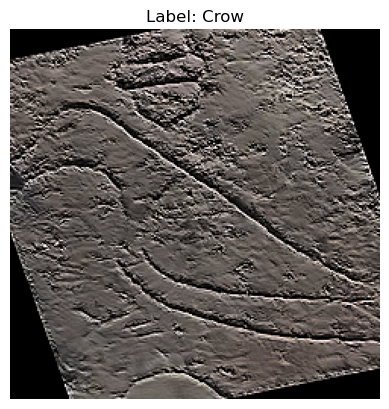

Shape: (244, 244, 3)
Dtype: float32
Min: 0.0 Max: 1.0


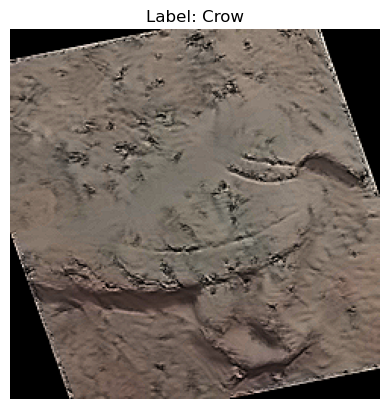

Shape: (244, 244, 3)
Dtype: float32
Min: 0.0 Max: 1.0


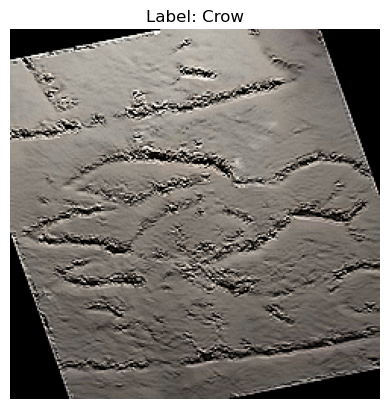

Shape: (244, 244, 3)
Dtype: float32
Min: 0.0 Max: 1.0


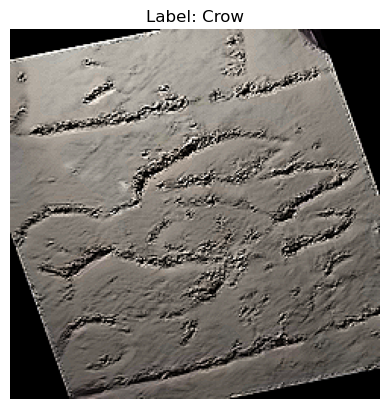

Shape: (244, 244, 3)
Dtype: float32
Min: 0.0 Max: 1.0


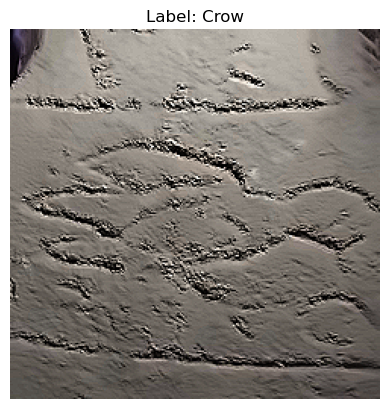

Shape: (244, 244, 3)
Dtype: float32
Min: 0.0 Max: 1.0


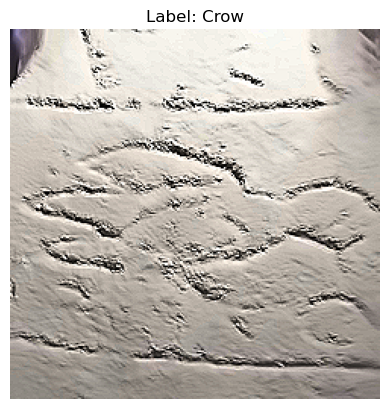

Shape: (244, 244, 3)
Dtype: float32
Min: 0.0 Max: 1.0


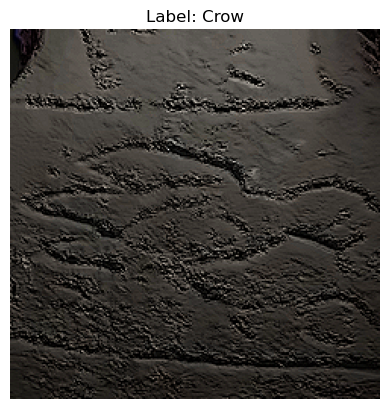

Shape: (244, 244, 3)
Dtype: float32
Min: 0.40392157 Max: 0.96862745


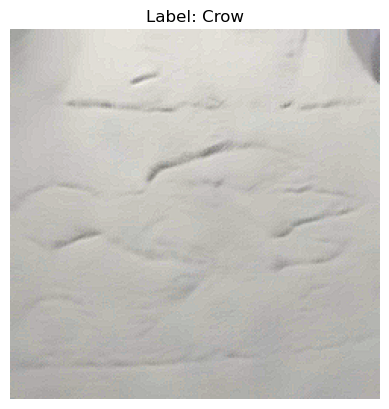

Shape: (244, 244, 3)
Dtype: float32
Min: 0.0 Max: 1.0


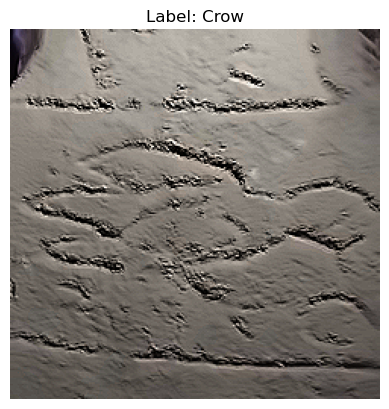

Shape: (244, 244, 3)
Dtype: float32
Min: 0.0 Max: 1.0


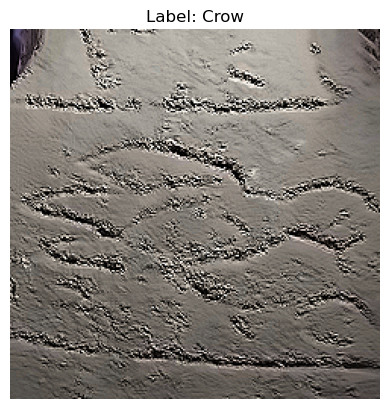

In [6]:
X, y, class_map = load_images_from_folder('dataset', image_size=(244, 244))
idx_to_class = {v: k for k, v in class_map.items()}

print("Loaded:", X.shape, "Labels:", y.shape)

# Apply full pipeline
X_processed = preprocess_images(X, augment=True, to_gray=False)  # Set to_gray=True if you want grayscale

# Show some examples with proper label names
for i in range(10):
    class_name = idx_to_class[y[i]]
    debug_image(X_processed[i], class_name)

In [7]:
def show_comparison(original, processed, label=None):
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    axs[0].imshow(original)
    axs[0].set_title("Original")
    axs[0].axis('off')

    axs[1].imshow(processed)
    axs[1].set_title("Processed")
    axs[1].axis('off')

    if label is not None:
        plt.suptitle(f"Label: {label}")
    plt.show()

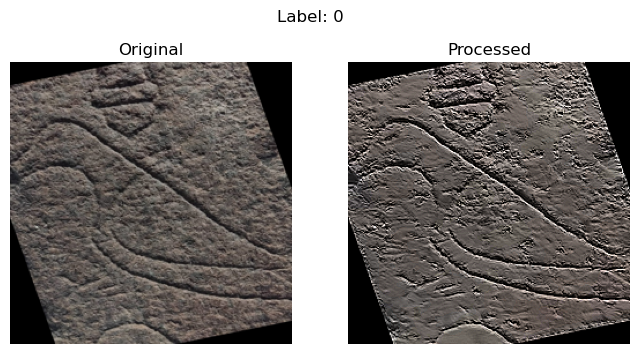

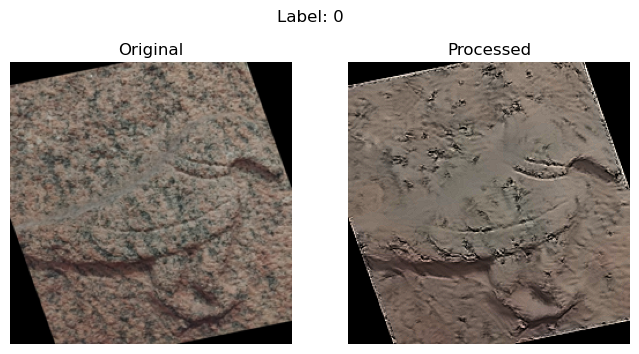

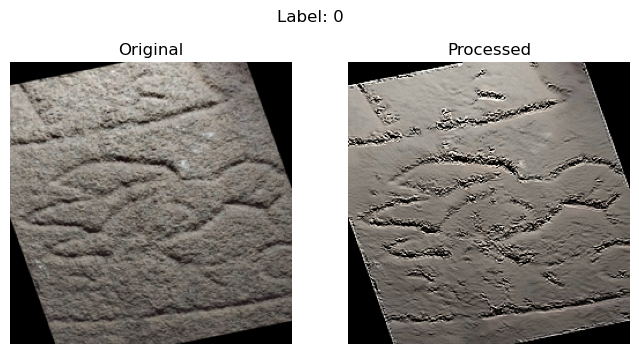

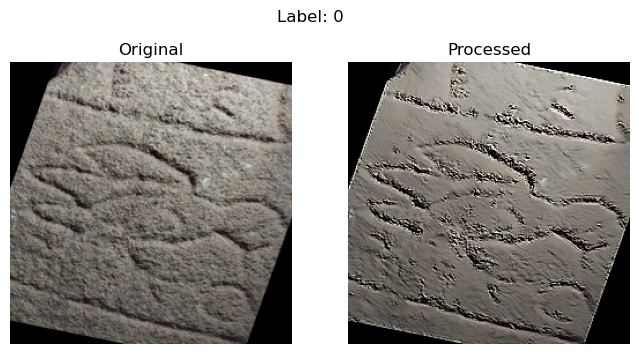

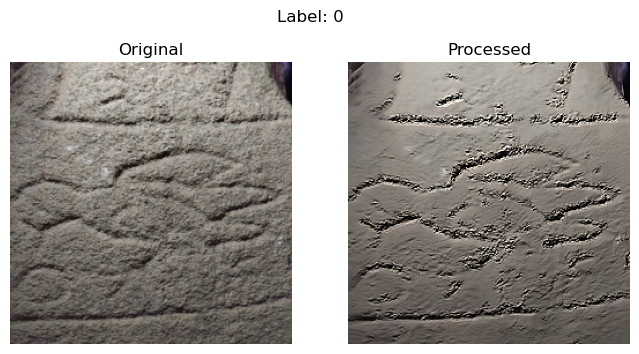

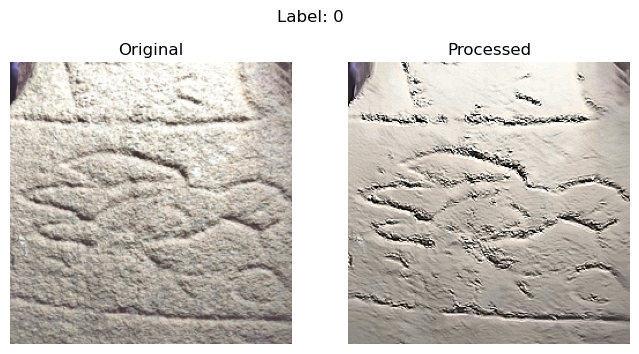

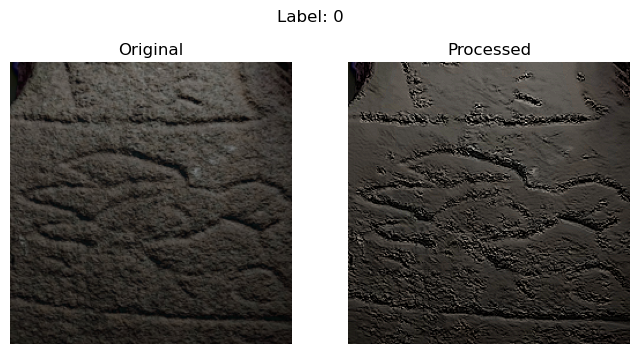

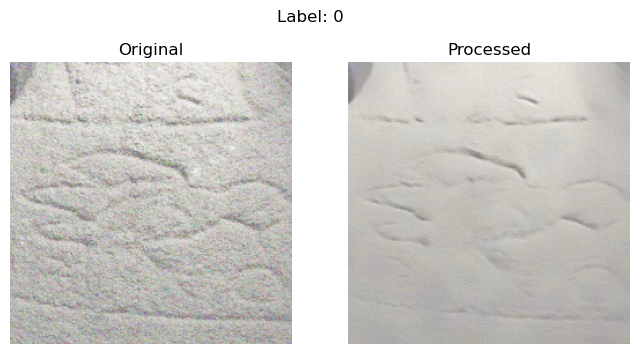

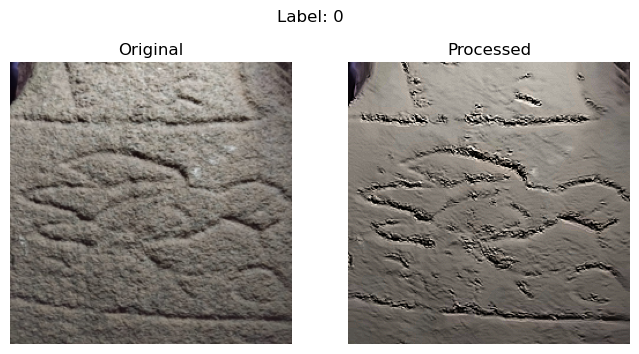

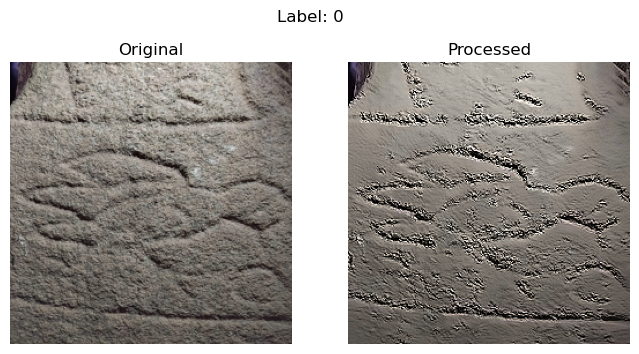

In [8]:
X, y, class_map = load_images_from_folder('dataset', image_size=(244, 244))
X_processed = preprocess_images(X, augment=False, to_gray=False)

# Compare images
for i in range(10):
    show_comparison(X[i], X_processed[i], y[i])

## Save the pre processed Data

In [9]:
np.save('X_processed.npy', X_processed)
np.save('y_labels.npy', y)
X_gray_processed = preprocess_images(X, augment=False, to_gray=True)

In [10]:
import os
import uuid
from PIL import Image

def save_processed_images(X_processed, y, class_map, output_root='pre_process_data'):
    os.makedirs(output_root, exist_ok=True)

    # Invert the class_map to get label -> class_name
    idx_to_class = {v: k for k, v in class_map.items()}

    for i, (img_array, label) in enumerate(zip(X_processed, y)):
        class_name = idx_to_class[label]
        class_folder = os.path.join(output_root, class_name)
        os.makedirs(class_folder, exist_ok=True)

        # Convert image array to uint8 format and save as image
        img_uint8 = (img_array * 255).astype(np.uint8)
        img_pil = Image.fromarray(img_uint8)

        # Ensure RGB format for saving
        if img_pil.mode != 'RGB':
            img_pil = img_pil.convert('RGB')

        # Unique filename
        filename = f"{uuid.uuid4().hex}.png"
        save_path = os.path.join(class_folder, filename)
        img_pil.save(save_path)

    print(f"Saved {len(X_processed)} images to '{output_root}/<class_name>/' folders.")

In [11]:
# Save color preprocessed images
save_processed_images(X_processed, y, class_map, output_root='pre_process_data')

# Save grayscale preprocessed images (if needed)
save_processed_images(X_gray_processed, y, class_map, output_root='pre_process_data_gray')

Saved 639 images to 'pre_process_data/<class_name>/' folders.
Saved 639 images to 'pre_process_data_gray/<class_name>/' folders.
